In [1]:
import numpy as np
import pandas as pd

from src.configspace import RANDOM_FOREST_CONFIGSPACE
from src.constant import HO, PROCESSED_DATA_DIR, RESULTS_BASE_DIR
from src.hyperparameter_optimization import optimize_hyperparameters
from src.model import SchmeeHahnQRF, RandomForestQuantileRegressor
from src.split import get_n_splits
from src.wrapper import StandardScaledLogTransformedWrapper
from src.evaluation import evaluate_model_with_cross_validation

In [2]:
evaluations_df = pd.read_parquet(PROCESSED_DATA_DIR / "evaluations.parquet")
solvers_df = pd.read_parquet(PROCESSED_DATA_DIR / "solvers.parquet")
instances_df = pd.read_parquet(PROCESSED_DATA_DIR / "instances.parquet")

df = pd.merge(evaluations_df, solvers_df, left_on="solver_id", right_on="id").drop(columns=["id"])
df = pd.merge(df, instances_df, left_on="instance_id", right_on="id").drop(columns=["id"])
df

,solver_id,instance_id,generator,cost,ASCENT_CANDIDATES,BACKBONE_TRIALS,BACKTRACKING,CANDIDATE_SET_TYPE,EXTRA_CANDIDATES,EXTRA_CANDIDATE_SET_TYPE,...,mst_dists_span,mst_dists_coef_of_var,mst_dists_sum,nnds_min,nnds_median,nnds_mean,nnds_max,nnds_sd,nnds_span,nnds_coef_of_var
0,1251473931473582278,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,4.74,0.95,1.0,0.0,0.0,0.2,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
1,2289112522627003788,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,0.02,0.15,0.0,1.0,1.0,0.4,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
2,960932965817811220,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,3.72,0.20,0.0,1.0,2.0,0.9,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
3,39012066323493184,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,1.52,0.60,1.0,1.0,2.0,0.7,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
4,494182449327999052,TSP/TRAIN/cluster_netgen/000.tsp,cluster_netgen,84.44,0.90,1.0,1.0,3.0,0.3,0.0,...,0.488488,1.790135,0.000225,0.000715,0.011143,0.014421,0.094965,0.012746,0.094250,0.883825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1286196444435323941,TSP/TRAIN/grid/019.tsp,grid,208.32,0.45,0.0,0.0,0.0,0.2,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99996,1435531534300921454,TSP/TRAIN/grid/019.tsp,grid,300.00,0.20,1.0,0.0,3.0,0.6,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99997,27607668447685341,TSP/TRAIN/grid/019.tsp,grid,3.21,0.95,1.0,1.0,3.0,0.9,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201
99998,2245205590089179674,TSP/TRAIN/grid/019.tsp,grid,17.23,0.65,0.0,0.0,1.0,0.5,0.0,...,0.093952,0.462330,0.000294,0.001335,0.029728,0.032519,0.095287,0.017339,0.093952,0.533201


In [3]:
SPLITS = get_n_splits(
    df=df,
    n=5,
    instance_number=10,
    solver_number=300,
    random_state=1,
)

In [4]:
train_idx, test_idx = SPLITS[0]

df_train = df.loc[train_idx]
df_test = df.loc[test_idx]

not_train_cols = ["solver_id", "instance_id", "generator", "cost"]
X_train = df_train.drop(columns=not_train_cols)
y_train = df_train["cost"].to_numpy()

X_test = df_test.drop(columns=not_train_cols)
y_test = df_test["cost"].to_numpy()
y_test_not_censored = y_test.copy()

cut_off_train = np.full(X_train.shape[0], 1.0)
cut_off_test = np.full(X_test.shape[0], 1.0)

y_train = np.clip(y_train, 0, cut_off_train)
y_test = np.clip(y_test, 0, cut_off_test)

X = X_train
y = y_train
cut_off = cut_off_train
k = 5

In [55]:
from scipy.stats import norm


def truncated_normal_mean(mu, sigma, C):
    sigma = np.where(sigma > 1e-5, sigma, 1e-5)
    alpha = (C - mu) / sigma
    denominator = 1 - norm.cdf(alpha)
    denominator = np.where(denominator > 1e-5, denominator, 1e-5)
    trunc_mean = mu + sigma * norm.pdf(alpha) / denominator
    return trunc_mean

In [56]:
quantiles = np.linspace(0.01, 0.99, 99).tolist()
not_censored = y < cut_off

qrf = RandomForestQuantileRegressor()
qrf.fit(X[not_censored], y[not_censored])

dict_ = {}
dict_[-1] = y.copy()

y_imputed = y.copy()

for i in range(k):
    Y_pred = qrf.predict(X[~not_censored], quantiles=quantiles)
    y_pred_mean = Y_pred.mean(axis=1)
    y_pred_std = (Y_pred[:, 83] - Y_pred[:, 15]) / 2
    y_imputed[~not_censored] = truncated_normal_mean(
        y_pred_mean, y_pred_std, cut_off[~not_censored]
    )

    qrf = RandomForestQuantileRegressor()
    qrf.fit(X, y_imputed)
    dict_[i] = y_imputed.copy()

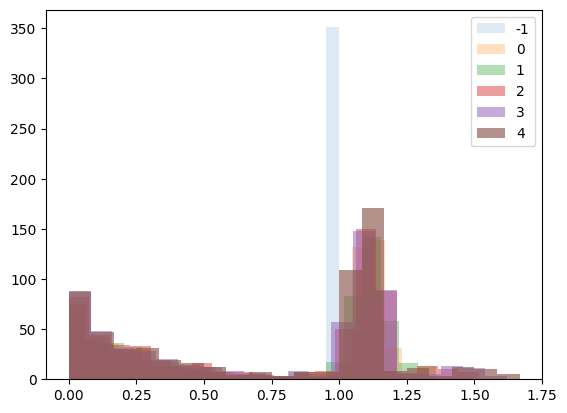

In [57]:
import matplotlib.pyplot as plt

for k, v in dict_.items():
    plt.hist(v, alpha=0.25 + k * 0.1, label=k, bins=20)

plt.legend()
plt.show()

In [4]:
wrapper = StandardScaledLogTransformedWrapper(
    model_cls=SchmeeHahnQRF,
    k=9,
    ccp_alpha=0.3427066131253,
    max_depth=14,
    max_features=0.9665097204233,
    min_samples_leaf=2,
    min_samples_split=32,
    ccp_alpha_rf=0.3427066131253,
    max_depth_rf=14,
    max_features_rf=0.9665097204233,
    min_samples_leaf_rf=2,
    min_samples_split_rf=32,
)

result = evaluate_model_with_cross_validation(
    df,
    wrapper=wrapper,
    splits=SPLITS,
    const_cut_off=1.0,
    random_state=1,
)

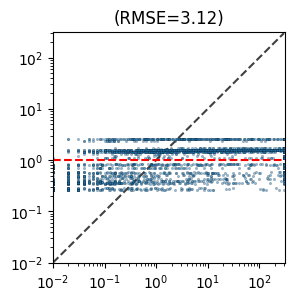

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3, 3))

ax.scatter(
    result["y_test_not_censored"],
    result["y_pred"],
    alpha=0.5,
    edgecolors="k",
    lw=0.2,
    s=3,
)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(0.01, 320)
ax.set_ylim(0.01, 320)
ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
ax.set_title(f'(RMSE={result["rmse"]:.2f})')
ax.axhline(y=1.0, color="red", linestyle="--")
plt.show()

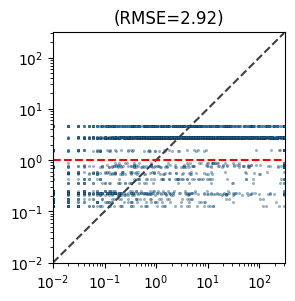

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(3, 3))

ax.scatter(
    result["y_test_not_censored"],
    result["y_pred"],
    alpha=0.5,
    edgecolors="k",
    lw=0.2,
    s=3,
)
ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlim(0.01, 320)
ax.set_ylim(0.01, 320)
ax.plot([0.01, 300], [0.01, 300], "k--", alpha=0.75, zorder=0)
ax.set_title(f'(RMSE={result["rmse"]:.2f})')
ax.axhline(y=1.0, color="red", linestyle="--")
plt.show()